In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage import exposure, io, transform
import matplotlib.pyplot as plt

2024-06-26 16:39:09.110582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 16:39:09.274757: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 16:39:09.279877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gustavo/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-06-26 16:39:09.279892: I 

In [2]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='./model/trafficsignnet_light.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
def returnRedness(img):
	yuv=cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
	y,u,v=cv2.split(yuv)
	return v

def threshold(img,T=150):
	_,img=cv2.threshold(img,T,255,cv2.THRESH_BINARY)
	return img 

def findContour(img):
	contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
	return contours

def findBiggestContour(contours):
	m = 0
	c = [cv2.contourArea(i) for i in contours]
	return contours[c.index(max(c))]

def boundaryBox(img,contours):
	x,y,w,h=cv2.boundingRect(contours)
	img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
	sign=img[y:(y+h) , x:(x+w)]
	return img,sign

def plot_img(image, title="", cmap='viridis'):
	plt.imshow(image, cmap=cmap)
	plt.title(title)
	plt.axis('off')
	plt.show()

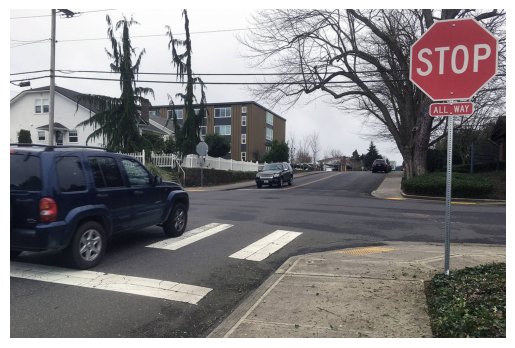

In [23]:
image = cv2.imread("./test/test2.jpg")

plot_img(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

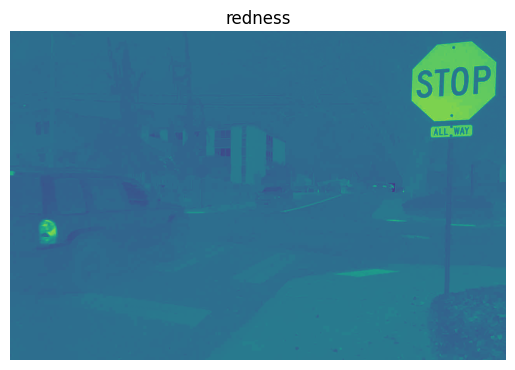

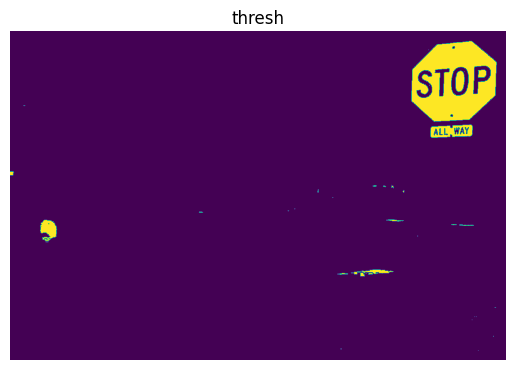

In [24]:
redness = returnRedness(image)
thresh = threshold(redness) 	

plot_img(redness, "redness")
plot_img(thresh, "thresh")

In [25]:
contours = findContour(thresh)
big = findBiggestContour(contours)
print(cv2.contourArea(big) > 3000)

True


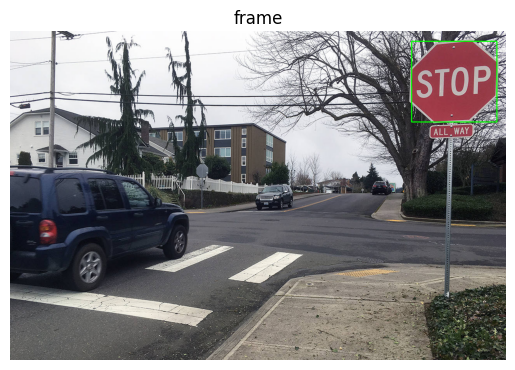

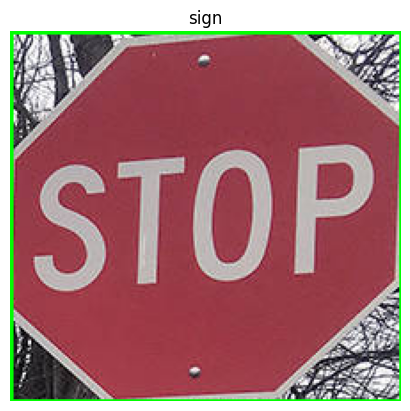

In [29]:
img, sign = boundaryBox(image, big)
plot_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'frame')
plot_img(cv2.cvtColor(sign, cv2.COLOR_BGR2RGB), 'sign')

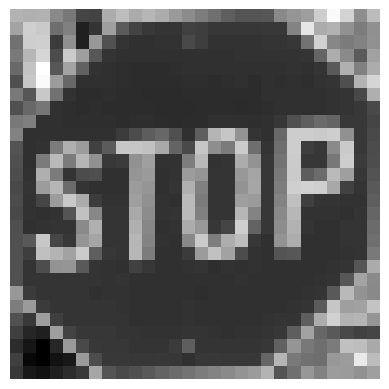

In [27]:
def preprocessingImageToClassifier2(image=None,imageSize=28,mu=89.77428691773054,std=70.85156431910688):
	image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
	image = cv2.resize(image,(imageSize,imageSize), interpolation=cv2.INTER_AREA)
	#image = np.expand_dims(image, axis=-1)
	image = (image - mu) / std
	#image = image.reshape(1,imageSize,imageSize,1)
	return image


proc_img = preprocessingImageToClassifier2(sign)

plot_img(proc_img, cmap='gray')

In [28]:
labelToText = {
	0: "Limite de Velocidade (30km/h)",
	1: "Pare",
	2: "Não entre",
	3: "Estrada em obras",
	4: "Pedestres",
	5: "Crianças",
	6: "Bicicletas",
	7: "Animais selvagens",
	8: "Siga em frente",
	9: "Mantenha a direita",
	10: "Mantenha a esquerda"
}

def preprocessingImageToClassifier(image=None, imageSize=28, mu=89.77428691773054, std=70.85156431910688):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (imageSize, imageSize))
    image = np.expand_dims(image, axis=-1)
    image = (image - mu) / std
    image = image.reshape(1, imageSize, imageSize, 1)
    return image.astype(np.float32)

def predict4(sign):
    img = preprocessingImageToClassifier(sign, imageSize=28)
    # Set the tensor to point to the input data to be inferred
    interpreter.set_tensor(input_details[0]['index'], img)
    # Run the inference
    interpreter.invoke()
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data)

result = labelToText[predict4(sign)]
print(result)

Pare
